In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import digits
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.utils import plot_model
from keras.layers import Embedding, SpatialDropout1D, LSTM, BatchNormalization, Dropout, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from nltk.corpus import stopwords
import string
import nltk
nltk.download('words')
nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
token = RegexpTokenizer("[\w']+")
sw = stopwords.words('english')
words = set(nltk.corpus.words.words())

# Get data sets and preprocessing fuctions

In [4]:
def get_datasets(): 
    columnLabels = ['country', 'id', 'title', 'c1', 'c2', 'c3', 'description', 'price', 'type']
    train = pd.read_csv("/content/drive/My Drive/product title classification/data_train.csv", names=columnLabels)
    test = pd.read_csv("/content/drive/My Drive/product title classification/data_test.csv", names=columnLabels)
    return train, test

def preprocess_df(dataframe): 
    df = pd.DataFrame()
    #tokenize and convert to lower case
    dataframe['title'] = dataframe['title'].apply(lambda x: token.tokenize(x.lower()))
    #stopword removal
    dataframe['title'] = dataframe['title'].apply(lambda x: ' '.join([w for w in x if w not in sw]))
    #remove punctuations and other symbols
    dataframe['title'] = dataframe['title'].apply(lambda x: [w for w in nltk.wordpunct_tokenize(x)\
                                                             if w is not w.isalpha() and not w.isnumeric()])
    #remove digits
    dataframe['title'] = dataframe['title'].apply(lambda x: [w.translate({ord(k): None for k in digits}) for w in x])
    #remove single length words
    dataframe['title'] = dataframe['title'].apply(lambda x: ' '.join([w for w in x if len(w)>1]))
    
    df['title'] = dataframe['title'].values
  
    df['c1'] = dataframe['c1'].values
    df['c2'] = dataframe['c2'].values
    df['c3'] = dataframe['c3'].values
    df['c3'] = df['c3'].replace(np.nan, 'none', regex=True)
    
    return df
    

AxesSubplot(0.125,0.125;0.775x0.755)


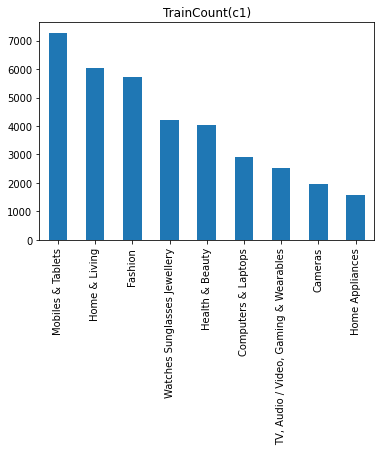

In [5]:
train_df, test_df = get_datasets()
tCol_df = preprocess_df(train_df)
tCol_df_test = preprocess_df(test_df)
print(train_df.c1.value_counts().plot(kind = 'bar', title = 'TrainCount(c1)'))

In [6]:
# tCol_df_test

# Create padded input sequences

In [7]:
maxWords = 20000
MaxWordLength = 50
tokenizer = Tokenizer(num_words = maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tCol_df['title'].values)

### Train input data sequences

In [8]:
train_X_c1 = tokenizer.texts_to_sequences((tCol_df['title']).values )
train_X_c1 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c1, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c1.shape)


train_X_c2 = tokenizer.texts_to_sequences((tCol_df['title']+' '+tCol_df['c1']).values )
train_X_c2 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c2, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c2.shape)


train_X_c3 = tokenizer.texts_to_sequences((tCol_df['title']+' '+tCol_df['c1']+' '+tCol_df['c2']).values )
train_X_c3 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c3, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c3.shape)

Shape of data tensor: (36283, 50)
Shape of data tensor: (36283, 50)
Shape of data tensor: (36283, 50)


### Test input data sequences

In [9]:
test_X_c1 = tokenizer.texts_to_sequences((tCol_df_test['title']).values)
test_X_c1 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c1, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c1.shape)


test_X_c2 = tokenizer.texts_to_sequences((tCol_df_test['title']+' '+tCol_df_test['c1']).values)
test_X_c2 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c2, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c2.shape)


test_X_c3 = tokenizer.texts_to_sequences((tCol_df_test['title']+' '+tCol_df_test['c1']+' '+tCol_df_test['c2']).values)
test_X_c3 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c3, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c3.shape)


Shape of test data tensor: (11838, 50)
Shape of test data tensor: (11838, 50)
Shape of test data tensor: (11838, 50)


# Y-label Encoding

## Train label encoding

In [10]:
train_Y_c1 = pd.get_dummies(tCol_df['c1']).values # one hot encoding
print('Shape of label tensor:', train_Y_c1.shape)

train_Y_c2 = pd.get_dummies(tCol_df['c2']).values # one hot encoding
print('Shape of label tensor:', train_Y_c2.shape)

train_Y_c3 = pd.get_dummies(tCol_df['c3']).values # one hot encoding
print('Shape of label tensor:', train_Y_c3.shape)



Shape of label tensor: (36283, 9)
Shape of label tensor: (36283, 57)
Shape of label tensor: (36283, 185)


## Test label encoding

In [11]:
test_Y_c1 = pd.get_dummies(tCol_df_test['c1']).values
print('Shape of test label tensor:', test_Y_c1.shape)

test_Y_c2 = pd.get_dummies(tCol_df_test['c2']).values
print('Shape of test label tensor:', test_Y_c2.shape)

test_Y_c3 = pd.get_dummies(tCol_df_test['c3']).values
print('Shape of test label tensor:', test_Y_c3.shape)

Shape of test label tensor: (11838, 9)
Shape of test label tensor: (11838, 57)
Shape of test label tensor: (11838, 185)


In [12]:
#print label decoding sequence

labels_c1=sorted(tCol_df['c1'].unique())
print(labels_c1)

labels_c2=sorted(tCol_df['c2'].unique())
print(labels_c2)

labels_c3=sorted(tCol_df['c3'].unique())
print(labels_c3)


['Cameras', 'Computers & Laptops', 'Fashion', 'Health & Beauty', 'Home & Living', 'Home Appliances', 'Mobiles & Tablets', 'TV, Audio / Video, Gaming & Wearables', 'Watches Sunglasses Jewellery']
['Accessories', 'Audio', 'Bath', 'Bath & Body', 'Beauty Tools', 'Bedding', 'Boys', 'Camera Accessories', 'Computer Accessories', 'Computer Components', 'Cooling & Heating', 'DSLR', 'Desktops Computers', 'Drones', 'Eyewear', 'Food Supplements', 'Fragrances', 'Furniture', 'Gadgets', 'Gadgets & Other Cameras', 'Gaming', 'Garment Care', 'Girls', 'Hair Care', 'Home Decor', 'Home Improvement', 'Housekeeping', 'Jewellery', 'Kitchen & Dining', 'Laptops', 'Large Appliances', 'Lenses', 'Lighting', 'Makeup', 'Medical Supplies', 'Men', "Men's Care", 'Mirrorless', 'Mobiles', 'Network Components', 'Outdoor & Garden', 'Personal Care', 'Point & Shoot', 'Printers & Accessories', 'Skin Care', 'Small Kitchen Appliances', 'Stationery', 'Storage', 'Storage & Organisation', 'TV Accessories', 'Tablets', 'Televisions'

# Create NN Architecture and Train Model - Category1

In [13]:
# c1_count=tCol_df['c1'].nunique()
# print(c1_count)
# embeddingDimensions = 100
# model_c1 = Sequential()
# model_c1.add(Embedding(maxWords, embeddingDimensions, input_length = train_X_c1.shape[1]))
# model_c1.add(LSTM(512, dropout=0.4, recurrent_dropout = 0.2))
# model_c1.add(Dense(128, activation='relu'))
# model_c1.add(Dense(c1_count, activation = 'softmax'))
# model_c1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model_c1.summary()

# epochs = 15
# batch_size = 64

# history1 = model_c1.fit(train_X_c1, train_Y_c1,
#                     validation_data=(test_X_c1, test_Y_c1),
#                     epochs = epochs, batch_size = batch_size,
#                     shuffle = True,
#                     # validation_split = 0.1,\
#                     callbacks = [EarlyStopping(monitor = 'val_accuracy', patience =3 , min_delta = 0.0001),
#                                  ModelCheckpoint('/content/drive/My Drive/product title classification/h_Models/model_c1/{val_accuracy:.3f}', save_weights_only=False)
#                     ]
#                     )




# Create NN Architecture and Train Model - Category2

In [14]:
# c2_count=tCol_df['c2'].nunique()
# print(c2_count)
# embeddingDimensions = 100
# model_c2 = Sequential()
# model_c2.add(Embedding(maxWords, embeddingDimensions, input_length = train_X_c2.shape[1]))
# model_c2.add(LSTM(512, dropout=0.4, recurrent_dropout = 0.2))
# model_c2.add(Dense(128, activation='relu'))
# model_c2.add(Dense(c2_count, activation = 'softmax'))
# model_c2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model_c2.summary()

# epochs = 15
# batch_size = 64

# history2 = model_c2.fit(train_X_c2, train_Y_c2,
#                     validation_data=(test_X_c2, test_Y_c2),
#                     epochs = epochs, batch_size = batch_size,
#                     shuffle = True,
#                     # validation_split = 0.1,\
#                     callbacks = [EarlyStopping(monitor = 'val_accuracy', patience =3 , min_delta = 0.0001),
#                                  ModelCheckpoint('/content/drive/My Drive/product title classification/h_Models/model_c2/{val_accuracy:.3f}', save_weights_only=False)
#                     ]
#                     )




# Create NN Architecture and Train Model - Category3

In [15]:
# c3_count=tCol_df['c3'].nunique()
# print(c3_count)

# embeddingDimensions = 100
# model_c3 = Sequential()
# model_c3.add(Embedding(maxWords, embeddingDimensions, input_length = train_X_c3.shape[1]))
# model_c3.add(LSTM(512, dropout=0.4, recurrent_dropout = 0.2))
# model_c3.add(Dense(256, activation='relu'))
# model_c3.add(Dense(c3_count, activation = 'softmax'))
# model_c3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model_c3.summary()

# epochs = 15
# batch_size = 64

# history3 = model_c3.fit(train_X_c3, train_Y_c3,
#                     validation_data=(test_X_c3, test_Y_c3),
#                     epochs = epochs, batch_size = batch_size,
#                     shuffle = True,
#                     # validation_split = 0.1,\
#                     callbacks = [EarlyStopping(monitor = 'val_accuracy', patience =3 , min_delta = 0.0001),
#                                  ModelCheckpoint('/content/drive/My Drive/product title classification/h_Models/model_c3/{val_accuracy:.3f}', save_weights_only=False)
#                     ]
#                     )




In [16]:
# accs=history1.history['accuracy']
# val_accs=history1.history['val_accuracy']
# plt.title('ACCURACY (on different runs)')
# plt.plot(range(len(accs)), accs, label='Training')
# plt.plot(range(len(accs)), val_accs, label='Validation')
# plt.legend()
# plt.show()

In [17]:
# accs=history2.history['accuracy']
# val_accs=history2.history['val_accuracy']
# plt.title('ACCURACY (on different runs)')
# plt.plot(range(len(accs)), accs, label='Training')
# plt.plot(range(len(accs)), val_accs, label='Validation')
# plt.legend()
# plt.show()

In [18]:
# accs=history3.history['accuracy']
# val_accs=history3.history['val_accuracy']
# plt.title('ACCURACY (on different runs)')
# plt.plot(range(len(accs)), accs, label='Training')
# plt.plot(range(len(accs)), val_accs, label='Validation')
# plt.legend()
# plt.show()

In [19]:
import glob
import os
l = glob.glob('/content/drive/My Drive/product title classification/h_Models/model_c1/*')
l = [format(float(os.path.basename(x)), '.3f') for x in l]
print(l)
m1 = max(l)
m1 

['0.912', '0.925', '0.919', '0.927', '0.928', '0.923', '0.920', '0.921']


'0.928'

In [20]:
l = glob.glob('/content/drive/My Drive/product title classification/h_Models/model_c2/*')
l = [format(float(os.path.basename(x)), '.3f') for x in l]
print(l)
m2 = max(l)
m2

['0.817', '0.866', '0.874', '0.889', '0.822', '0.878', '0.888', '0.887', '0.891', '0.892', '0.884', '0.882', '0.886']


'0.892'

In [21]:
l = glob.glob('/content/drive/My Drive/product title classification/h_Models/model_c3/*')
l = [format(float(os.path.basename(x)), '.3f') for x in l]
print(l)
m3 = max(l)
m3

['0.645', '0.728', '0.766', '0.792', '0.800', '0.807', '0.812', '0.808', '0.810', '0.815', '0.811', '0.814']


'0.815'

# Load Model

In [22]:
model_c1=tf.keras.models.load_model('/content/drive/My Drive/product title classification/h_Models/model_c1/{}'.format(m1))

In [23]:
model_c2=tf.keras.models.load_model('/content/drive/My Drive/product title classification/h_Models/model_c2/{}'.format(m2))

In [24]:
model_c3=tf.keras.models.load_model('/content/drive/My Drive/product title classification/h_Models/model_c3/{}'.format(m3))

# Prediction on test set

In [25]:
ynew_c1 = model_c1.predict_classes(test_X_c1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [26]:
ynew_c2 = model_c2.predict_classes(test_X_c2)

In [27]:
ynew_c3 = model_c3.predict_classes(test_X_c3)

In [ ]:
# show the inputs and predicted outputs
for i in range(len(test_X_c1)):
	print("%d --> X=%s, --> Predicted=%s, Actual=%s" % (i, tCol_df_test['title'][i], labels_c1[ynew_c1[i]], tCol_df_test['c1'][i]))


# Title Prediction on real time example

In [28]:
new_x=[]

x = str(input("Enter the product title : "))

# title preprocessing
new_x.append(x)
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c1 prediction
pred1 = model_c1.predict(padded)
print('Category 1: ',labels_c1[np.argmax(pred1)])

# concatenate title + c1
new_x[0]=new_x[0]+' '+labels_c1[np.argmax(pred1)]

# title + c1 preprocessing
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c2 prediction
pred2 = model_c2.predict(padded)
print('Category 2: ',labels_c2[np.argmax(pred2)])

# concatenate title + c1 + c2
new_x[0]=new_x[0]+' '+labels_c2[np.argmax(pred2)]

# title + c1 + c2 preprocessing
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c3 prediction
pred3 = model_c3.predict(padded)
print('Category 3: ',labels_c3[np.argmax(pred3)])


# pred[0][np.argmax(pred)

Enter the product title : pendant
Category 1:  Watches Sunglasses Jewellery
Category 2:  Jewellery
Category 3:  Women


# Model Evaluation

In [29]:
acc = model_c1.evaluate(test_X_c1, test_Y_c1)
ModelAccuracy1 = acc[1]
print('ModelAccuracy for c1 =',round(acc[1],2)*100,'%')
model_c1.summary()

370/370 [==============================] - 16s 44ms/step - loss: 0.2567 - accuracy: 0.9285
ModelAccuracy for c1 = 93.0 %
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dense_15 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_16 (Dense)             (None, 9)                 1161      
Total params: 3,322,249
Trainable params: 3,322,249
Non-trainable params: 0
_________________________________________________________________


In [30]:
acc = model_c2.evaluate(test_X_c2, test_Y_c2)
ModelAccuracy2 = acc[1]
print('ModelAccuracy for c2 =',round(acc[1],2)*100,'%')
model_c2.summary()

370/370 [==============================] - 15s 40ms/step - loss: 0.4111 - accuracy: 0.8924
ModelAccuracy for c2 = 89.0 %
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dense_17 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_18 (Dense)             (None, 57)                7353      
Total params: 3,328,441
Trainable params: 3,328,441
Non-trainable params: 0
_________________________________________________________________


In [31]:
acc = model_c3.evaluate(test_X_c3, test_Y_c3)
ModelAccuracy3 = acc[1]
print('ModelAccuracy for c3 =',round(acc[1],2)*100,'%')
model_c3.summary()

370/370 [==============================] - 15s 40ms/step - loss: 0.7172 - accuracy: 0.8148
ModelAccuracy for c3 = 81.0 %
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           2000000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 512)               1255424   
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_20 (Dense)             (None, 185)               47545     
Total params: 3,434,297
Trainable params: 3,434,297
Non-trainable params: 0
_________________________________________________________________


## Overall Accuracy

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [32]:
Overall_accuracy = ((ModelAccuracy1+ModelAccuracy2+ModelAccuracy3)/3)*100
print("Overall Model accuracy is: ", round(Overall_accuracy,3),'%')

Overall Model accuracy is:  87.855 %


In [49]:
def y_conversion(y_onehot):
    y_labels=[]
    # print(y_onehot[0:15])
    for i in y_onehot:
        y_labels.append(np.argmax(i))
    y_labels = np.asarray(y_labels)
    # print(type(y_labels[0:15]), y_labels[0:15])
    
    return y_labels

y1 = y_conversion(test_Y_c1)
accuracy = accuracy_score(y1, ynew_c1)
print("\n----------for category 1----------")
print('Accuracy: %f' % accuracy)
kappa = cohen_kappa_score(y1, ynew_c1)
print('Cohens kappa: %f' % kappa)

print("\n----------for category 2----------")
y2 = y_conversion(test_Y_c2)
accuracy = accuracy_score(y2, ynew_c2)
print('Accuracy: %f' % accuracy)
kappa = cohen_kappa_score(y2, ynew_c2)
print('Cohens kappa: %f' % kappa)

print("\n----------for category 3----------")
y3 = y_conversion(test_Y_c3)
accuracy = accuracy_score(y3, ynew_c3)
print('Accuracy: %f' % accuracy)
kappa = cohen_kappa_score(y3, ynew_c3)
print('Cohens kappa: %f' % kappa)


----------for category 1----------
Accuracy: 0.928451
Cohens kappa: 0.917371

----------for category 2----------
Accuracy: 0.892380
Cohens kappa: 0.884982

----------for category 3----------
Accuracy: 0.814834
Cohens kappa: 0.808762


In [47]:
# accuracy: (tp + tn) / (p + n)
# print(test_Y_c1[0], ynew_c1[0])

# oh_yp1=pd.get_dummies(ynew_c1).values
# print("test\n",test_Y_c1,oh_yp1)
# m = tf.keras.metrics.Recall()
# m.update_state(test_Y_c1, ynew_c1)
# m.result().numpy()

# accuracy = accuracy_score(y1, ynew_c1)
# print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# precision = precision_score(y1, ynew_c1, average=None)
# print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# recall = recall_score(y1, ynew_c1)
# print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(y1, ynew_c1, average='weighted')
# print('F1 score: %f' % f1)
 

# confusion matrix
# matrix = confusion_matrix(test_Y_c1, oh_yp1)
# print(matrix)

# Loaded Model Architectures

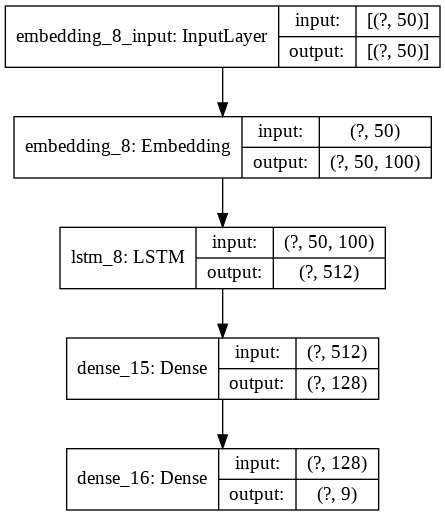

In [50]:
plot_model(model_c1, show_shapes=True)

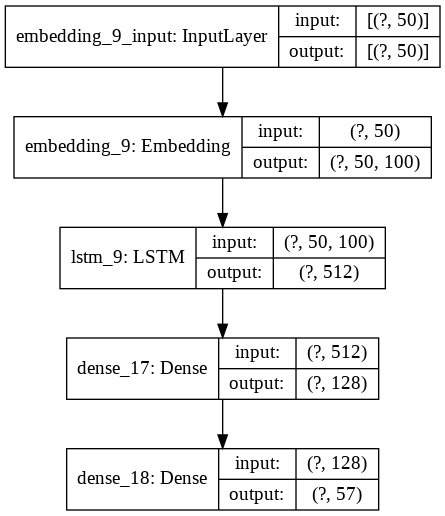

In [51]:
plot_model(model_c2, show_shapes=True)

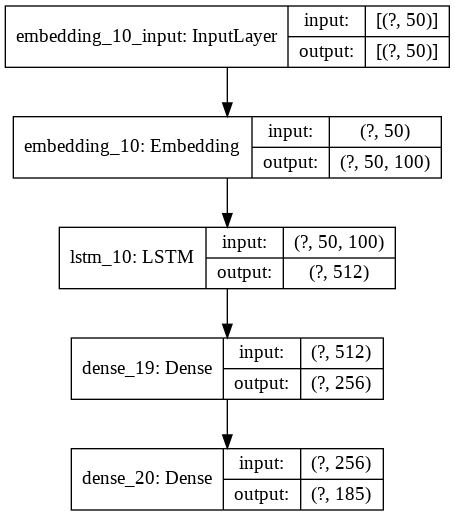

In [52]:
plot_model(model_c3, show_shapes=True)